The vanishing gradient problem: cumulative back-propagated error signals either shrink rapidly, or grow out of bounds. They decay exponentially in the number of layers, or they explode. The result is that the final trained network converges to a poor local minimum.

Activation (non-linear) functions that do not saturate:

   Rectifier Linear Unit, ReLU: $y=max(0,x)$, $y \in [0,\infty]$, learning rate $\alpha \rightarrow 0$

Leaky ReLU: $y=max(s·x,x)$ , typically $s=0.01$

Exponential Linear Unit, ELU: $y=s(e^{x}-1$), usually $s=1$. if $s=1$, then $y \in [-1,\infty]$ 

# Reading data

Same function as previous examples:

In [1]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from sklearn.preprocessing import OneHotEncoder
from time import time

In [2]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
file_name = "notMNIST.pickle"
def make_datasets (file, n_training_samples=0, n_dev_samples=0, 
                   n_testing_samples=0, one_hot=False):
    with open (file,'rb') as f:
        dataset = pickle.load(f)
        f.close

    train_dataset = dataset['train_dataset']
    train_labels = dataset['train_labels']
    dev_dataset = dataset['valid_dataset']
    dev_labels = dataset['valid_labels']
    test_dataset = dataset['test_dataset']
    test_labels = dataset['test_labels']

    #Prepare training, dev (validation) and final testing data. 
    #It has to be reshaped since (n_samples, n_fatures) are expected

    all_training_samples, width, height = train_dataset.shape
    train_attributes = np.reshape(train_dataset, (all_training_samples, 
                                                  width * height))
    if (n_training_samples != 0):
        train_attributes = train_attributes[0:n_training_samples]
        train_labels = train_labels[0:n_training_samples]

    all_dev_samples, width, height = dev_dataset.shape
    dev_attributes = np.reshape(dev_dataset,
                                       (all_dev_samples, width * height))
    if (n_dev_samples != 0):
        dev_attributes = dev_attributes[0:n_dev_samples]
        dev_labels = dev_labels[0:n_dev_samples]

    all_testing_samples, width, height = test_dataset.shape
    test_attributes = np.reshape(test_dataset, (all_testing_samples, width * height))
    if (n_testing_samples != 0):
        test_attributes = test_attributes[0:n_testing_samples]
        test_labels = test_labels[0:n_testing_samples]

    # If one-hot encoding is requested, then funtion OneHotEcoding 
    # from SciKit-Learn is called    
    if one_hot:
        enc = OneHotEncoder(sparse=False)
        # Labels are one-dimensional vectors, 
        # and are reshaped to matrices of one column
        train_labels = enc.fit_transform(train_labels.reshape(len(train_labels),1))
        dev_labels = enc.fit_transform(dev_labels.reshape(len(dev_labels), 1))
        test_labels = enc.fit_transform(test_labels.reshape(len(test_labels), 1))

    return (train_attributes, train_labels, dev_attributes, 
            dev_labels, test_attributes, test_labels)

In [4]:
#EDITED TO REFLECT THE ASSIGNMENT SPECS
NUM_TRAINING_SAMPLES = 10000
NUM_DEV_SAMPLES = 1000
NUM_TESTING_SAMPLES = 1000

In [5]:
x_train, y_train, x_dev, y_dev, x_test, y_test = make_datasets(file_name, 
                                 n_training_samples=NUM_TRAINING_SAMPLES,
                                 n_dev_samples=NUM_DEV_SAMPLES, 
                                 n_testing_samples=NUM_TESTING_SAMPLES,
                                 one_hot=True)

# Building the 28x28-300-200-100-10 deep neural network

Hyper-paramenters configuration:

In [14]:
n_epochs = 10000
epochs_to_display = 200
batch_size = 200
learning_rate = 0.01

TOT_EPOCS=10000

n_inputs = len(x_train[0])
n_hidden1 = 300
n_hidden2 = 200
n_hidden3 = 100
n_outputs = len(y_train[0])

First, the input __X__ and target __t__ matrices are defined as placeholders:

In [7]:
with tf.name_scope("io"):
    X = tf.placeholder(dtype=tf.float32, shape=(None,n_inputs), name="X")
    t = tf.placeholder(dtype=tf.float32, shape=(None,n_outputs), name="t")

Then, the neural network topology is defined: A full-connected 28x28-300-200-100-10 deep neural network. Note that ReLU is the activation function for the hidden layers, and linear logits with softmax for the output. net_out represents the logits of the output layer.

In [8]:
with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    net_out = tf.layers.dense(hidden3, n_outputs, name="net_out")
    y = tf.nn.softmax(logits=net_out, name="y")
    rounded_y = tf.round(y)

# Loss and cost functions with cross entropy and log-loss

In [9]:
with tf.name_scope("loss"):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=t, logits=net_out)
    mean_log_loss = tf.reduce_mean(cross_entropy, name="mean_loss")

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



# Defining the learning algorithm: gradient descent with back-prop

In [10]:
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(mean_log_loss)

# Evaluating the model

In [11]:
correct_predictions = tf.equal(tf.argmax(y, 1), tf.argmax(t, 1))
accuracy = tf.reduce_mean(tf.cast(correct_predictions,tf.float32))

# Modifications

## Optimization Algorithms

First question we should ask ourself, is the bias low-enough?
Right now the difference between train error and human error (supposed to be 0 in this example) is roughly 3%. We have no measure to define if this is low or high given that we have no definitive threshold.

What we can do is trying to change optimization method in order to lower the number of epocs needed for the full training. We think that doing this now will give us more chances to try different strategies for variance reduction.

We will accept another optimization method only if it will keep or improve the actual bias. In case of ties, we will pick the one with best variabilty and/or the most simple one.

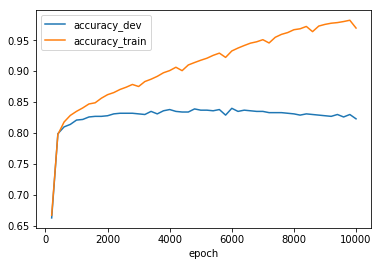

In [39]:
baseline_results.plot()

it is quite clear that the slope of the train accuracy if far from "nice". Also we already witnessthe dev accuracy to increase, thus signaling overfitting. Notes the spikes, very strange...

### Exponential Decay

In [17]:
initial_learning_rate = 0.1
decay_steps = 10000
decay_rate = 0.96
global_step = tf.Variable(0, trainable=False, name="global_step")
learning_rate = tf.train.exponential_decay(initial_learning_rate,
global_step, decay_steps,
decay_rate)
optimizer = tf.train.MomentumOptimizer(learning_rate, momentum=0.9)
train_step = optimizer.minimize(mean_log_loss, global_step=global_step)


In [18]:
exp_decay_results, run_time = run(TOT_EPOCS)

200 Train accuracy:  0.7092 Development accuracy:  0.7
400 Train accuracy:  0.8973 Development accuracy:  0.836
600 Train accuracy:  0.9369 Development accuracy:  0.832
800 Train accuracy:  0.9575 Development accuracy:  0.832
1000 Train accuracy:  0.9747 Development accuracy:  0.839
1200 Train accuracy:  0.9878 Development accuracy:  0.838
1400 Train accuracy:  0.9792 Development accuracy:  0.836
1600 Train accuracy:  0.9842 Development accuracy:  0.832
1800 Train accuracy:  0.9893 Development accuracy:  0.845
2000 Train accuracy:  0.9899 Development accuracy:  0.832
2200 Train accuracy:  0.9928 Development accuracy:  0.845
2400 Train accuracy:  0.9947 Development accuracy:  0.843
2600 Train accuracy:  0.9945 Development accuracy:  0.836
2800 Train accuracy:  0.9904 Development accuracy:  0.834
3000 Train accuracy:  0.9921 Development accuracy:  0.836
3200 Train accuracy:  0.9911 Development accuracy:  0.828
3400 Train accuracy:  0.9947 Development accuracy:  0.84
3600 Train accuracy: 

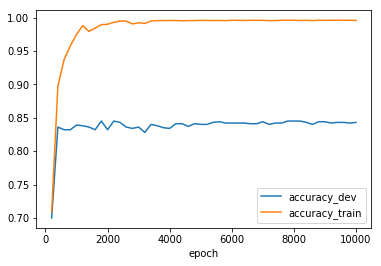

In [19]:
exp_decay_results.plot()

In [20]:
exp_decay_results.iloc[-1]

accuracy_dev      0.8430
accuracy_train    0.9956
Name: 10000, dtype: float64

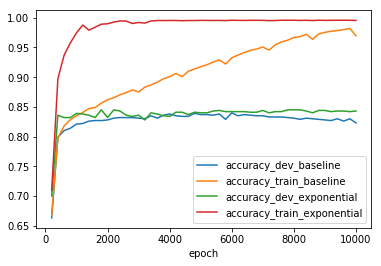

In [26]:
baseline_results.join(exp_decay_results, lsuffix='_baseline', rsuffix='_exponential').plot()

So we reduced sensibly the bias without impacting the variance. From the data we can see that we can reduce the number of epocs to 5k, thus gaining 50% of the time.

### Momentum 

In [23]:
optimizer = tf.train.MomentumOptimizer(learning_rate=0.1, momentum=0.9)
train_step = optimizer.minimize(mean_log_loss, global_step=global_step)

In [27]:
momentum_results, momentum_time = run(TOT_EPOCS)

200 Train accuracy:  0.7194 Development accuracy:  0.712
400 Train accuracy:  0.8936 Development accuracy:  0.842
600 Train accuracy:  0.933 Development accuracy:  0.823
800 Train accuracy:  0.954 Development accuracy:  0.842
1000 Train accuracy:  0.9763 Development accuracy:  0.852
1200 Train accuracy:  0.9857 Development accuracy:  0.849
1400 Train accuracy:  0.9858 Development accuracy:  0.846
1600 Train accuracy:  0.9842 Development accuracy:  0.845
1800 Train accuracy:  0.9858 Development accuracy:  0.847
2000 Train accuracy:  0.9898 Development accuracy:  0.851
2200 Train accuracy:  0.9924 Development accuracy:  0.852
2400 Train accuracy:  0.99 Development accuracy:  0.854
2600 Train accuracy:  0.9947 Development accuracy:  0.862
2800 Train accuracy:  0.9939 Development accuracy:  0.852
3000 Train accuracy:  0.9943 Development accuracy:  0.855
3200 Train accuracy:  0.995 Development accuracy:  0.856
3400 Train accuracy:  0.9921 Development accuracy:  0.847
3600 Train accuracy:  0

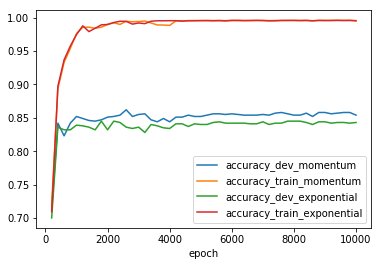

In [30]:
momentum_results.join(exp_decay_results, lsuffix='_momentum', rsuffix='_exponential').plot()

So, same execution time, same number of iterations to reach stability, but better variance. Fot this reason momentum appears to be better

### Nesterov accellerated gradient

In [31]:
optimizer = tf.train.MomentumOptimizer(learning_rate=0.1, momentum=0.9,
use_nesterov=True)
train_step = optimizer.minimize(mean_log_loss, global_step=global_step)

In [32]:
nesterov_results, nesterov_time = run(TOT_EPOCS)

200 Train accuracy:  0.72 Development accuracy:  0.711
400 Train accuracy:  0.9071 Development accuracy:  0.826
600 Train accuracy:  0.9543 Development accuracy:  0.826
800 Train accuracy:  0.9627 Development accuracy:  0.82
1000 Train accuracy:  0.9777 Development accuracy:  0.824
1200 Train accuracy:  0.9871 Development accuracy:  0.839
1400 Train accuracy:  0.9909 Development accuracy:  0.827
1600 Train accuracy:  0.9905 Development accuracy:  0.839
1800 Train accuracy:  0.9925 Development accuracy:  0.851
2000 Train accuracy:  0.9894 Development accuracy:  0.84
2200 Train accuracy:  0.9925 Development accuracy:  0.843
2400 Train accuracy:  0.9931 Development accuracy:  0.835
2600 Train accuracy:  0.9936 Development accuracy:  0.837
2800 Train accuracy:  0.9953 Development accuracy:  0.856
3000 Train accuracy:  0.9948 Development accuracy:  0.85
3200 Train accuracy:  0.9955 Development accuracy:  0.847
3400 Train accuracy:  0.9957 Development accuracy:  0.848
3600 Train accuracy:  0

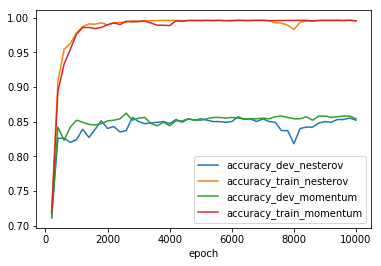

In [34]:
nesterov_results.join(momentum_results, lsuffix="_nesterov", rsuffix="_momentum").plot()

nestorev does not seem to be a noticeable improvement, we are going to keep momentum, given that it is simpler

### Adam

In [35]:
optimizer = tf.train.AdamOptimizer(learning_rate= 0.001)
train_step = optimizer.minimize(mean_log_loss, global_step=global_step)


In [36]:
adam_results, adam_time = run(TOT_EPOCS)

200 Train accuracy:  0.713 Development accuracy:  0.718
400 Train accuracy:  0.9143 Development accuracy:  0.839
600 Train accuracy:  0.9677 Development accuracy:  0.845
800 Train accuracy:  0.9746 Development accuracy:  0.841
1000 Train accuracy:  0.9891 Development accuracy:  0.844
1200 Train accuracy:  0.9915 Development accuracy:  0.833
1400 Train accuracy:  0.9892 Development accuracy:  0.837
1600 Train accuracy:  0.9929 Development accuracy:  0.843
1800 Train accuracy:  0.9895 Development accuracy:  0.836
2000 Train accuracy:  0.9934 Development accuracy:  0.832
2200 Train accuracy:  0.9937 Development accuracy:  0.839
2400 Train accuracy:  0.988 Development accuracy:  0.82
2600 Train accuracy:  0.9911 Development accuracy:  0.829
2800 Train accuracy:  0.9933 Development accuracy:  0.842
3000 Train accuracy:  0.9945 Development accuracy:  0.851
3200 Train accuracy:  0.9844 Development accuracy:  0.841
3400 Train accuracy:  0.9917 Development accuracy:  0.835
3600 Train accuracy: 

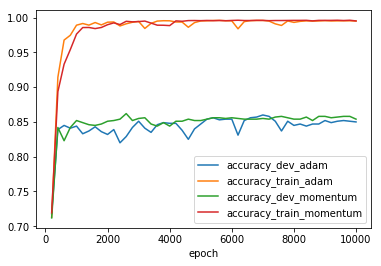

In [37]:
adam_results.join(momentum_results, lsuffix="_adam", rsuffix="_momentum").plot()

Adam is faster as prmosed in reaching the maximum train accuracy, but the dev accuracy show some strange patterns.

The gain is not worth it. We will stick with momentum

## Next step: weight initialization
Weight initialization should affect mainly the training time, hence we should try it now, before getting to the variance.

## Next step: pick an activation function and stick with it

## Next step: batch normalization should fasten the learning

## Next step: get really going with variance

# Executing the model

In [24]:
init = tf.global_variables_initializer()

In [12]:
def run(n_epochs, initialize = True):
    if initialize : 
        init = tf.global_variables_initializer()
    with tf.Session() as sess:
        start_time = time()
        various_metrics = []
        sess.run(init)
        for epoch in range (int(n_epochs / epochs_to_display)):
            for iteration in range (epochs_to_display):
                offset = (iteration * epoch * batch_size) % (y_train.shape[0] - batch_size)
                sess.run(train_step, feed_dict={X: x_train[offset:(offset+batch_size),:],
                                                t: y_train[offset:(offset+batch_size),:]})
            accuracy_train = accuracy.eval(feed_dict={X: x_train, t: y_train})
            accuracy_dev = accuracy.eval(feed_dict={X: x_dev, t: y_dev})
            print((epoch+1)*epochs_to_display, "Train accuracy: ", accuracy_train, 
                  "Development accuracy: ", accuracy_dev)
            various_metrics.append({"epoch":(epoch+1)*epochs_to_display, "accuracy_train": accuracy_train, "accuracy_dev" :accuracy_dev})

        accuracy_test = accuracy.eval(feed_dict={X: x_test, t: y_test})
        #print ("Test accuracy: ", accuracy_test)
        print ("Target values:\n", y_test[0:10], "\nComputed values:\n", 
               rounded_y.eval(feed_dict={X: x_test[0:10]}))
        print ("First 10 Predictions: ", 
               correct_predictions.eval(feed_dict={X: x_test[0:10], t: y_test[0:10]}))
        print ("Elapsed time: ", time()-start_time, "secs.")
        return pd.DataFrame(various_metrics).set_index("epoch") , time()-start_time

In [15]:
baseline_results, baseline_time = run(TOT_EPOCS)

200 Train accuracy:  0.6674 Development accuracy:  0.663
400 Train accuracy:  0.7977 Development accuracy:  0.799
600 Train accuracy:  0.8179 Development accuracy:  0.81
800 Train accuracy:  0.8285 Development accuracy:  0.814
1000 Train accuracy:  0.8351 Development accuracy:  0.821
1200 Train accuracy:  0.8406 Development accuracy:  0.822
1400 Train accuracy:  0.847 Development accuracy:  0.826
1600 Train accuracy:  0.8489 Development accuracy:  0.827
1800 Train accuracy:  0.8563 Development accuracy:  0.827
2000 Train accuracy:  0.862 Development accuracy:  0.828
2200 Train accuracy:  0.8654 Development accuracy:  0.831
2400 Train accuracy:  0.8704 Development accuracy:  0.832
2600 Train accuracy:  0.8741 Development accuracy:  0.832
2800 Train accuracy:  0.8785 Development accuracy:  0.832
3000 Train accuracy:  0.8752 Development accuracy:  0.831
3200 Train accuracy:  0.8832 Development accuracy:  0.83
3400 Train accuracy:  0.887 Development accuracy:  0.835
3600 Train accuracy:  0

In [16]:
baseline_results

,accuracy_dev,accuracy_train
epoch,,
200,0.663,0.6674
400,0.799,0.7977
600,0.810,0.8179
800,0.814,0.8285
1000,0.821,0.8351
1200,0.822,0.8406
1400,0.826,0.8470
1600,0.827,0.8489
1800,0.827,0.8563


baseline reuslts are 97% for train accuracy and 82% for development accuracy

time: 65seconds

__Results with respect to one-hidden layer model:__ 

Train: $85\% \rightarrow 97\%$; Development: $81\% \rightarrow 84\%$; Final test: $87\% \rightarrow 90\%$

This deep model involves a total of __600 neurons__ distributed across three hidden layers, __instead of 1,000__ neurons in the just one-hidden layer model.